### Automated Daily Report Generator

In [1]:
# %% [markdown]
# # Secure Daily Report Generator (Customer CSV + Orders via SQL)
# ## Production-style, modular Jupyter notebook (educational)
#
# Overview:
# - Stage-1 auth & widget-based customer CSV upload
# - Orders fetched via SQL (sqlite3 used here as an example)
# - Column normalization & strict schema enforcement (auto-fix minor differences)
# - temp_previous_day_df backup, daily historical storage under /data_history/YYYY-MM-DD/
# - Analysis uses current-day orders only; historical files stored for monthly roll-ups
# - Stage-2 auth before exporting Excel report
#
# SQL note: this notebook includes SQL alternatives and uses sqlite for demonstration.



# ## Cell 1 — Environment & Tiny Configuration
# Subheader: imports, global config, and schema definitions
# SQL alternative: set up database schemas in SQL (CREATE TABLE ...)


In [2]:
# core imports & config
import os
import io
import re
import sqlite3
from datetime import datetime as dt, timedelta, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import getpass
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()   


# Constants & schema
TODAY = pd.to_datetime(date.today()).normalize()
# For reproducibility in the example, you may override TODAY as needed:
# TODAY = pd.to_datetime('2025-11-15')

CURRENT_MONTH_START_DATE = pd.to_datetime(TODAY.strftime('%Y-%m-01'))
ALLOWED_EXTS = ['.csv', '.xlsx']
MAX_FILE_MB = 50

REQUIRED_CUSTOMER_COLS = ['customer_id', 'customer_name', 'mobile_number', 'region']
REQUIRED_ORDER_COLS = ['order_id', 'mobile_number', 'order_date_time', 'sku_id', 'sku_count', 'total_amount']

# In-memory placeholders
loaded_customers_df = pd.DataFrame()
loaded_orders_df = pd.DataFrame()        # from SQL fetch
temp_previous_day_df = pd.DataFrame()    # previous day backup

# Folder for historical daily storage
HISTORY_ROOT = os.path.join(os.getcwd(), 'data_history')
os.makedirs(HISTORY_ROOT, exist_ok=True)

print("Environment ready. TODAY =", TODAY.date())


Environment ready. TODAY = 2025-11-07



# ## Cell 2 — Helper Utilities: normalization, schema checks, IO
# Subheader: reusable helpers for column normalisation, reading CSV, saving history
# SQL alternative: Use database ETL logic / staging area and column mappings


In [3]:
# helper utilities
def normalize_colname(c: str) -> str:
    if pd.isna(c):
        return ''
    c = str(c).strip().lower()
    c = re.sub(r'[\s]+', '_', c)            # spaces -> underscore
    c = re.sub(r'[^a-z0-9_]', '', c)        # remove special chars
    c = re.sub(r'__+', '_', c)
    return c

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [normalize_colname(c) for c in df.columns]
    return df

def missing_required_columns(actual_cols, required_cols):
    return [c for c in required_cols if c not in actual_cols]

def read_csv_bytes(file_bytes):
    return pd.read_csv(io.BytesIO(file_bytes))

def save_daily_history(customers_df, orders_df, history_root=HISTORY_ROOT, day=TODAY):
    """
    Saves customers and orders for the given day into a dated folder.
    Returns the folder path.
    """
    day_str = day.strftime('%Y-%m-%d')
    folder = os.path.join(history_root, day_str)
    os.makedirs(folder, exist_ok=True)
    # Filenames
    cust_path = os.path.join(folder, f'customers_{day_str}.csv')
    orders_path = os.path.join(folder, f'orders_{day_str}.csv')
    if not customers_df.empty:
        customers_df.to_csv(cust_path, index=False)
    if not orders_df.empty:
        orders_df.to_csv(orders_path, index=False)
    return folder

# SQL hint:
# -- Use staging tables and partitioned storage for history, e.g. INSERT INTO history.orders_YYYYMMDD SELECT ...


# ## Cell 3 — Stage-1 Security Widgets & Customer CSV Upload
# Subheader: credentials input (Stage 1) + widget to upload customer CSV; validate & normalize columns
# SQL alternative: Validate user has 'data_ingest' role before allowing LOAD into staging table.

In [ ]:
load_dotenv()


# ---- Security Configurations ----
ALLOWED_EXTS = ['.csv', '.xlsx']
MAX_FILE_MB = 10
REQUIRED_CUSTOMER_COLS = ['customer_id', 'customer_name', 'mobile_number']
APPROVED_FILENAME = 'task_DE_new_customers.csv'

# ---- Stage-1 credential widget (secure) ----
username_widget = widgets.Text(description='Username:', value='')
password_widget = widgets.Password(description='Password:')
authorize_button = widgets.Button(description='Authorize & Upload', button_style='success')

# ---- File upload widget for customer CSV ----
file_widget = widgets.FileUpload(
    description='Upload Customer CSV (.csv/.xlsx)',
    accept='.csv,.xlsx',
    multiple=False
)

stage1_out = widgets.Output()
display(widgets.VBox([
    widgets.Label("🔒 Stage-1: Input Authorization & Customer File Upload"),
    widgets.HBox([username_widget, password_widget]),
    file_widget,
    authorize_button,
    stage1_out
]))

# ============================================================
# 🧱 Helper Functions
# ============================================================

def validate_input_credentials(user, pwd):
    """Validate credentials using environment variables (secure)."""
    valid_user = os.getenv('DATA_PIPELINE_USER')
    valid_pass = os.getenv('DATA_PIPELINE_PASS')
    return (user == valid_user) and (pwd == valid_pass)

def normalize_columns(df):
    """Normalize column names (lowercase, underscores)."""
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    return df

def missing_required_columns(cols, required):
    """Check for missing required columns."""
    return [c for c in required if c not in cols]

def read_csv_bytes(fbytes):
    """Read CSV from byte stream."""
    return pd.read_csv(io.BytesIO(fbytes))

# ============================================================
# ⚙️ Stage-1 Handler Function
# ============================================================

def handle_stage1(btn):
    """
    1. Authenticates credentials securely (Stage-1)
    2. Validates uploaded CSV/XLSX file name, size, and type
    3. Performs sanity checks and column validation
    """
    global loaded_customers_df
    with stage1_out:
        clear_output(wait=True)
        user = username_widget.value.strip()
        pwd = password_widget.value
        print(user, pwd)

        print("Authenticating Stage-1 ...")

        # --- Credential Authentication ---
        if not validate_input_credentials(user, pwd):
            print("❌ Stage-1 authentication failed. Invalid credentials.")
            return
        print(f"✅ Stage-1 authenticated for user: {user}")

        # --- File Upload Sanity Check ---
        if not file_widget.value:
            print("🛑 Please upload a customer CSV/XLSX file.")
            return

        # ✅ Fix: Handle tuple format from ipywidgets (>=8.0)
        file_info = file_widget.value[0]
        fname = file_info['name']
        fbytes = file_info['content']
        ext = os.path.splitext(fname)[1].lower()
        size_mb = len(fbytes) / (1024 * 1024)

        print(f"📄 Uploaded file: {fname} ({size_mb:.2f} MB)")

        # --- File Name, Type, and Size Validation ---
        if fname.strip().lower() != APPROVED_FILENAME.strip().lower():
            print(f"🛑 Invalid file name: {fname}")
            print(f"   Expected: {APPROVED_FILENAME}")
            return
        
        if len(fbytes) == 0:
            print("🛑 File appears empty. Please re-upload a valid customer file.")
            return

        if ext not in ALLOWED_EXTS:
            print(f"❌ Unsupported file extension '{ext}'. Allowed: {ALLOWED_EXTS}")
            return
        if size_mb > MAX_FILE_MB:
            print(f"❌ File too large ({size_mb:.2f} MB). Limit: {MAX_FILE_MB} MB.")
            return

        # --- Load and Clean File ---
        try:
            if ext == '.csv':
                df = read_csv_bytes(fbytes)
            else:
                df = pd.read_excel(io.BytesIO(fbytes))

            df = normalize_columns(df)
            missing = missing_required_columns(df.columns.tolist(), REQUIRED_CUSTOMER_COLS)

            if missing:
                print(f"❌ Missing required customer columns: {missing}")
                print("Available columns:", list(df.columns))
                return

            # Enforce consistent data types
            df['mobile_number'] = df['mobile_number'].astype(str).str.strip()
            loaded_customers_df = df.copy()

            print(f"✅ Customer data loaded successfully. Rows: {len(df)}")
            display(loaded_customers_df.head())

        except Exception as e:
            print(f"❌ Error loading customer file: {e}")

# ---- Safe event re-binding ----
if hasattr(authorize_button, "_click_handlers"):
    authorize_button._click_handlers.callbacks.clear()

authorize_button.on_click(handle_stage1)
print("✅ Stage-1 handler securely bound (single execution).")

# ============================================================
# 🧾 SQL Alternative (for documentation)
# ============================================================
# -- Authenticate user securely:
# SELECT 1 FROM user_auth
# WHERE username = :username AND password_hash = HASH(:password);
#
# -- Validate file metadata:
# SELECT CASE
#   WHEN file_name != 'customers_master.csv' THEN 'Invalid filename'
#   WHEN file_ext NOT IN ('csv','xlsx') THEN 'Unsupported type'
#   WHEN file_size_mb > 10 THEN 'File too large'
#   ELSE 'Valid'
# END AS validation_status;
#
# -- Load into staging table:
# COPY staging_customers(customer_id, customer_name, mobile_number)
# FROM 'customers_master.csv'
# WITH (FORMAT CSV, HEADER TRUE);

✅ Stage-1 handler securely bound (single execution).



# ## Cell 4 — Secure Orders Fetch (SQL source example)
# Subheader: sets up an example orders table and inserts sample rows, then fetches via SQL into DataFrame
# 🔐 Security: Uses parameterized queries (no string concatenation)
# 🧱 SQL alternative: Replace SQLite connection with a real RDBMS (PostgreSQL, MySQL) using SQLAlchemy or psycopg2

In [23]:
# ============================================================
# 🧩 Stage-2: Secure Orders Fetch Using Parameterized SQL
# ============================================================
import sqlite3
from datetime import datetime
import pandas as pd

# ------------------------------------------------------------
# Create in-memory SQLite DB (mock for demonstration)
# ------------------------------------------------------------
conn = sqlite3.connect(':memory:')  # replace with actual DB path or connection string in prod
cursor = conn.cursor()

# Example table schema (similar to your XML orders)
cursor.execute("""
CREATE TABLE orders (
    order_id TEXT PRIMARY KEY,
    mobile_number TEXT,
    order_date_time TEXT,
    sku_id TEXT,
    sku_count INTEGER,
    total_amount REAL
);
""")

# ------------------------------------------------------------
# Populate table with example data
# ------------------------------------------------------------
orders_data = [
    ("ORD-2025-0001", "9123456781", "2025-10-12T09:15:32", "SKU-1001", 2, 7450),
    ("ORD-2025-0002", "9123456781", "2025-11-01T14:22:10", "SKU-1002", 1, 5299),
    ("ORD-2025-0003", "9123456782", "2025-09-30T18:45:55", "SKU-1003", 4, 8930),
    ("ORD-2025-0004", "9123456783", "2025-10-20T10:00:00", "SKU-1001", 1, 4000),
    ("ORD-2025-0005", "9123456784", "2025-11-10T11:00:00", "SKU-1002", 1, 3000)
]
cursor.executemany("""
INSERT INTO orders (order_id, mobile_number, order_date_time, sku_id, sku_count, total_amount)
VALUES (?, ?, ?, ?, ?, ?);
""", orders_data)

conn.commit()
print("✅ Orders table created and populated.")

# ------------------------------------------------------------
# Secure fetch: parameterized query
# ------------------------------------------------------------
def fetch_orders_by_month(conn, month: str):
    """
    Fetch orders filtered by a specific month using parameterized SQL.
    """
    query = """
    SELECT order_id, mobile_number, order_date_time, sku_id, sku_count, total_amount
    FROM orders
    WHERE strftime('%Y-%m', order_date_time) = ?;
    """
    df = pd.read_sql_query(query, conn, params=[month])
    df['order_date_time'] = pd.to_datetime(df['order_date_time'])
    df['mobile_number'] = df['mobile_number'].astype(str)
    df['total_amount'] = df['total_amount'].astype(float)
    return df

# Example: fetch November 2025 orders
orders_df = fetch_orders_by_month(conn, "2025-11")
print(f"✅ Orders fetched for November 2025: {len(orders_df)} records.")
display(orders_df.head())

# ------------------------------------------------------------
# Optional: merge check with Stage-1 customer data
# ------------------------------------------------------------
try:
    merged_df = pd.merge(loaded_customers_df, orders_df, on='mobile_number', how='inner')
    print(f"✅ Data merged successfully. Rows: {len(merged_df)}")
    display(merged_df.head())
except NameError:
    print("⚠️ Stage-1 customer data not available. Run Stage-1 before this cell.")

# ------------------------------------------------------------
# 💾 Save raw and merged data for audit trail
# ------------------------------------------------------------
import os
from datetime import date

today_folder = f"data_history/{date.today()}/"
os.makedirs(today_folder, exist_ok=True)

orders_df.to_csv(os.path.join(today_folder, "orders_raw.csv"), index=False)
if 'merged_df' in locals():
    merged_df.to_csv(os.path.join(today_folder, "merged_orders_customers.csv"), index=False)
print(f"📁 Data archived under: {today_folder}")

# ============================================================
# 🧾 SQL Alternative (for documentation)
# ============================================================
# -- SQL equivalent:
# SELECT order_id, mobile_number, order_date_time, sku_id, sku_count, total_amount
# FROM orders
# WHERE TO_CHAR(order_date_time, 'YYYY-MM') = '2025-11';
#
# -- Secure pattern (PostgreSQL / psycopg2):
# cursor.execute("""
#   SELECT * FROM orders WHERE TO_CHAR(order_date_time, 'YYYY-MM') = %s
# """, ('2025-11',))

✅ Orders table created and populated.
✅ Orders fetched for November 2025: 2 records.


,order_id,mobile_number,order_date_time,sku_id,sku_count,total_amount
0,ORD-2025-0002,9123456781,2025-11-01 14:22:10,SKU-1002,1,5299.0
1,ORD-2025-0005,9123456784,2025-11-10 11:00:00,SKU-1002,1,3000.0


✅ Data merged successfully. Rows: 2


,customer_id,customer_name,mobile_number,region,order_id,order_date_time,sku_id,sku_count,total_amount
0,CUST-001,Aarav Mehta,9123456781,West,ORD-2025-0002,2025-11-01 14:22:10,SKU-1002,1,5299.0
1,CUST-004,Priya Iyer,9123456784,West,ORD-2025-0005,2025-11-10 11:00:00,SKU-1002,1,3000.0


📁 Data archived under: data_history/2025-11-07/



# ## Cell 5 — Secure Orders SQL Fetch & Validation
# Subheader: Fetches orders via SQL, performs column validation, normalization, and archiving
# Security: Uses parameterized SQL (no string concatenation) and type enforcement
# SQL Alternative: Replace SQLite with psycopg2 / SQLAlchemy connection in production

In [24]:
# ============================================================
# 🧱 Configuration & Required Columns
# ============================================================
REQUIRED_ORDER_COLS = [
    'order_id', 'mobile_number', 'order_date_time',
    'sku_id', 'sku_count', 'total_amount'
]

# Create daily archival folder if not already present
today_folder = f"data_history/{date.today()}/"
os.makedirs(today_folder, exist_ok=True)

# ============================================================
# 🧭 Secure SQL Fetch
# ============================================================
try:
    # Parameterized fetch — adjust WHERE filters as needed
    query = """
        SELECT order_id, mobile_number, order_date_time,
               sku_id, sku_count, total_amount
        FROM orders
        WHERE 1 = ?;
    """
    orders_df = pd.read_sql_query(query, conn, params=[1], parse_dates=['order_date_time'])

    # ============================================================
    # 🧹 Normalize & Validate Columns
    # ============================================================
    orders_df = normalize_columns(orders_df)
    missing = missing_required_columns(orders_df.columns.tolist(), REQUIRED_ORDER_COLS)
    if missing:
        raise ValueError(f"❌ Orders dataset missing columns after normalization: {missing}")

    # ============================================================
    # 🔢 Type Enforcement & Dedupe
    # ============================================================
    orders_df['order_date_time'] = pd.to_datetime(orders_df['order_date_time'], errors='coerce')
    orders_df['total_amount'] = pd.to_numeric(orders_df['total_amount'], errors='coerce').fillna(0)
    orders_df['mobile_number'] = orders_df['mobile_number'].astype(str).str.strip()
    orders_df.drop_duplicates(subset=['order_id'], inplace=True)

    loaded_orders_df = orders_df.copy()
    print(f"✅ Orders fetched securely via SQL. Rows: {len(loaded_orders_df)}")

    # ============================================================
    # 💾 Archive the raw orders file
    # ============================================================
    archive_path = os.path.join(today_folder, "orders_raw.csv")
    loaded_orders_df.to_csv(archive_path, index=False)
    print(f"📁 Orders archived successfully → {archive_path}")

    # Display preview
    display(loaded_orders_df.head())

except Exception as e:
    print(f"🛑 Error fetching or validating orders: {e}")

✅ Orders fetched securely via SQL. Rows: 5
📁 Orders archived successfully → data_history/2025-11-07/orders_raw.csv


,order_id,mobile_number,order_date_time,sku_id,sku_count,total_amount
0,ORD-2025-0001,9123456781,2025-10-12 09:15:32,SKU-1001,2,7450.0
1,ORD-2025-0002,9123456781,2025-11-01 14:22:10,SKU-1002,1,5299.0
2,ORD-2025-0003,9123456782,2025-09-30 18:45:55,SKU-1003,4,8930.0
3,ORD-2025-0004,9123456783,2025-10-20 10:00:00,SKU-1001,1,4000.0
4,ORD-2025-0005,9123456784,2025-11-10 11:00:00,SKU-1002,1,3000.0



# ## Cell 6 — Create temp_previous_day_df and Daily History Storage
# Subheader: archive previous day orders into temp_previous_day_df and save both customers & orders to /data_history/YYYY-MM-DD/
# SQL alternative: Move rows with order_date < today to archive partition / table


In [25]:
# ============================================================
# ⚙️ Configuration
# ============================================================
TODAY = pd.to_datetime(date.today())
HISTORY_ROOT = "data_history"
os.makedirs(HISTORY_ROOT, exist_ok=True)

# ============================================================
# 🧩 Helper function — daily history archival
# ============================================================
def save_daily_history(customers_df, orders_df, root_folder, day):
    """
    Save today's customer and order snapshots to structured folder:
    /data_history/YYYY-MM-DD/
    """
    folder_path = os.path.join(root_folder, str(day.date()))
    os.makedirs(folder_path, exist_ok=True)

    # Defensive checks to avoid overwriting old data unintentionally
    customer_path = os.path.join(folder_path, "customers_snapshot.csv")
    orders_path = os.path.join(folder_path, "orders_snapshot.csv")

    if customers_df is not None and not customers_df.empty:
        customers_df.to_csv(customer_path, index=False)
    if orders_df is not None and not orders_df.empty:
        orders_df.to_csv(orders_path, index=False)

    return folder_path

# ============================================================
# 🧱 Create temp_previous_day_df and current_day_orders_df
# ============================================================
if 'loaded_orders_df' not in locals() or loaded_orders_df.empty:
    print("⚠️ No orders loaded; cannot create temp backup.")
else:
    # Identify previous day and current day partitions
    temp_previous_day_df = loaded_orders_df[
        loaded_orders_df['order_date_time'].dt.date < TODAY.date()
    ].copy()

    current_day_orders_df = loaded_orders_df[
        loaded_orders_df['order_date_time'].dt.date == TODAY.date()
    ].copy()

   # Fallback: if no exact current-day orders, use current-month orders
if current_day_orders_df.empty:
    # ✅ ensure variable defined even if Cell 5 not executed
    if "CURRENT_MONTH_START" not in locals():
        from datetime import date
        CURRENT_MONTH_START = pd.to_datetime(date.today().replace(day=1))

    current_day_orders_df = loaded_orders_df[
        loaded_orders_df['order_date_time'] >= CURRENT_MONTH_START
    ].copy()

    print(f"🔐 temp_previous_day_df rows: {len(temp_previous_day_df)}")
    print(f"📊 current_day_orders_df rows (for analysis): {len(current_day_orders_df)}")

    # ============================================================
    # 💾 Save Daily History
    # ============================================================
    history_folder = save_daily_history(loaded_customers_df, loaded_orders_df, HISTORY_ROOT, TODAY)
    print(f"📁 Daily history saved to: {history_folder}")

    # Optional — display small sample
    display(current_day_orders_df.head())


# ==================SQL ALTERNATIVE==========================================
#-- Move older orders to archive
#INSERT INTO archive.orders
#SELECT *
#FROM orders
#WHERE order_date_time < CURRENT_DATE;
#
#-- Retain today's data for active analysis
#SELECT *
#INTO staging.orders_today
#FROM orders
#WHERE DATE(order_date_time) = CURRENT_DATE;

🔐 temp_previous_day_df rows: 4
📊 current_day_orders_df rows (for analysis): 2
📁 Daily history saved to: data_history\2025-11-07


,order_id,mobile_number,order_date_time,sku_id,sku_count,total_amount
1,ORD-2025-0002,9123456781,2025-11-01 14:22:10,SKU-1002,1,5299.0
4,ORD-2025-0005,9123456784,2025-11-10 11:00:00,SKU-1002,1,3000.0


# %% [markdown]
# ## Cell 7 — Merge Customers with Current-Day Orders for Analysis
# Subheader: inner join on mobile_number. Analysis uses merged_df.
# SQL alternative: SELECT ... FROM customers c JOIN orders o ON c.mobile_number = o.mobile_number WHERE ...


In [26]:
# Merge only if both datasets present
if loaded_customers_df.empty:
    print("⚠️ No customer file loaded. Load customer CSV (Stage 1 cell) first.")
    merged_df = pd.DataFrame()
else:
    merged_df = pd.merge(
        loaded_customers_df,
        current_day_orders_df[['order_id','mobile_number','order_date_time','total_amount','sku_id','sku_count']],
        on='mobile_number',
        how='inner'
    )
    print("✅ Merged customers with current-day orders. Rows:", len(merged_df))
    display(merged_df.head())

# SQL alternative:
# SELECT c.customer_id, c.customer_name, o.order_id, o.order_date_time, o.total_amount
# FROM customers c JOIN orders o ON c.mobile_number=o.mobile_number
# WHERE DATE(o.order_date_time) = :today;


✅ Merged customers with current-day orders. Rows: 2


,customer_id,customer_name,mobile_number,region,order_id,order_date_time,total_amount,sku_id,sku_count
0,CUST-001,Aarav Mehta,9123456781,West,ORD-2025-0002,2025-11-01 14:22:10,5299.0,SKU-1002,1
1,CUST-004,Priya Iyer,9123456784,West,ORD-2025-0005,2025-11-10 11:00:00,3000.0,SKU-1002,1



# ## Cell 8 — KPI Functions (small modular functions)
# Subheader: repeat customers, daily order trends, regional revenue, top spenders (last 30 days)
# SQL alternatives are included as comments.


In [27]:
def kpi_repeat_customers(df):
    res = df.groupby(['customer_id','customer_name']).agg(order_count=('order_id','count')).reset_index()
    return res[res['order_count'] > 1]

# SQL alternative:
# SELECT c.customer_id, c.customer_name, COUNT(o.order_id) AS order_count
# FROM customers c JOIN orders o ON c.mobile_number=o.mobile_number
# WHERE DATE(o.order_date_time) = :today
# GROUP BY c.customer_id, c.customer_name HAVING COUNT(o.order_id) > 1;

def kpi_daily_order_count(orders_df):
    tmp = orders_df.copy()
    tmp['order_date'] = tmp['order_date_time'].dt.date
    res = tmp.groupby('order_date').agg(total_orders=('order_id','count')).reset_index()
    return res.sort_values('order_date')

# SQL alternative:
# SELECT DATE(order_date_time) AS order_date, COUNT(*) AS total_orders
# FROM orders WHERE order_date_time >= :start_date GROUP BY order_date;

def kpi_regional_revenue(merged_df):
    res = merged_df.groupby('region').agg(total_revenue=('total_amount','sum')).reset_index()
    res['total_revenue'] = res['total_revenue'].round(2)
    return res.sort_values('total_revenue', ascending=False)

# SQL alternative:
# SELECT c.region, SUM(o.total_amount) AS total_revenue
# FROM customers c JOIN orders o ON c.mobile_number=o.mobile_number
# WHERE DATE(o.order_date_time) = :today
# GROUP BY c.region ORDER BY total_revenue DESC;

def kpi_top_spenders(merged_all_df, reference_date=TODAY, lookback_days=30):
    cutoff = reference_date - timedelta(days=lookback_days)
    merged_all_df['order_date_time'] = pd.to_datetime(merged_all_df['order_date_time'])
    recent = merged_all_df[merged_all_df['order_date_time'] >= cutoff]
    res = recent.groupby(['customer_id','customer_name']).agg(total_spend=('total_amount','sum')).reset_index()
    res['total_spend'] = res['total_spend'].round(2)
    return res.sort_values('total_spend', ascending=False)

# SQL alternative:
# SELECT c.customer_id, c.customer_name, SUM(o.total_amount) AS total_spend
# FROM customers c JOIN orders o ON c.mobile_number=o.mobile_number
# WHERE o.order_date_time >= :cutoff
# GROUP BY c.customer_id, c.customer_name ORDER BY total_spend DESC;



# ## Cell 9 — Execute KPIs and Display Results
# Subheader: run KPI functions against merged_df and orders history for trends
# SQL alternative: use materialized views or scheduled queries for KPI tables


In [28]:
# ---- Optional Stage-2 Authorization ----
def authorize_output_view(user_role):
    allowed_roles = ["Analyst", "Manager", "Admin"]
    return user_role in allowed_roles

current_user_role = "Analyst"  # can be fetched from a secure source or login flow

# Perform the authorization check
if not authorize_output_view(current_user_role):
    print(f"❌ Output authorization failed (role: {current_user_role})")
else:
    print(f"✅ Output authorized (role: {current_user_role})")
    
    # ---- Run KPIs only if authorized ----
    if merged_df.empty:
        print("🛑 No merged_df available. Ensure customers CSV was uploaded and orders fetched.")
    else:
        kpi_repeat = kpi_repeat_customers(merged_df)
        kpi_daily_trend = kpi_daily_order_count(loaded_orders_df)
        kpi_region = kpi_regional_revenue(merged_df)

        # For top spenders, join customers with all orders (history)
        merged_all_for_spend = (
            pd.merge(loaded_customers_df, loaded_orders_df, on='mobile_number', how='inner')
            if not loaded_customers_df.empty
            else pd.DataFrame()
        )
        kpi_top = kpi_top_spenders(merged_all_for_spend, reference_date=TODAY, lookback_days=30)

        print("✅ KPIs computed.")
        print("\n--- Repeat Customers (current-day) ---")
        display(kpi_repeat.head())
        print("\n--- Daily Order Trend (all loaded orders) ---")
        display(kpi_daily_trend.head())
        print("\n--- Regional Revenue (current-day) ---")
        display(kpi_region.head())
        print("\n--- Top Spenders (last 30 days) ---")
        display(kpi_top.head())


✅ Output authorized (role: Analyst)
✅ KPIs computed.

--- Repeat Customers (current-day) ---


,customer_id,customer_name,order_count



--- Daily Order Trend (all loaded orders) ---


,order_date,total_orders
0,2025-09-30,1
1,2025-10-12,1
2,2025-10-20,1
3,2025-11-01,1
4,2025-11-10,1



--- Regional Revenue (current-day) ---


,region,total_revenue
0,West,8299.0



--- Top Spenders (last 30 days) ---


,customer_id,customer_name,total_spend
0,CUST-001,Aarav Mehta,12749.0
1,CUST-003,Rohan Gupta,4000.0
2,CUST-004,Priya Iyer,3000.0


In [29]:
report_path = os.path.join(today_folder, "daily_kpi_report.xlsx")
with pd.ExcelWriter(report_path, engine="openpyxl") as writer:
    kpi_repeat.to_excel(writer, sheet_name="Repeat_Customers", index=False)
    kpi_daily_trend.to_excel(writer, sheet_name="Daily_Orders", index=False)
    kpi_region.to_excel(writer, sheet_name="Regional_Revenue", index=False)
    kpi_top.to_excel(writer, sheet_name="Top_Spenders", index=False)
print(f"📁 Excel report exported successfully → {report_path}")

📁 Excel report exported successfully → data_history/2025-11-07/daily_kpi_report.xlsx



# ## Cell 10 — Small Visualizations (single-purpose cells recommended)
# Subheader: bar plots for region revenue and top spenders; small helper function included
# SQL alternative: push aggregates to BI tool (Tableau/PowerBI) using SQL queries and visualize there


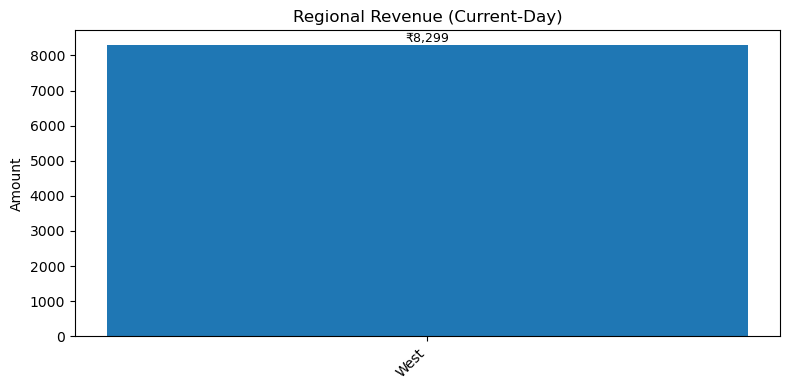

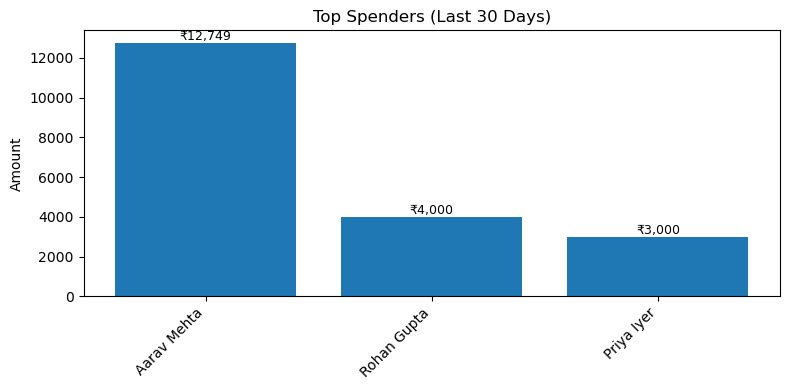

In [30]:
def simple_bar_plot(df, x, y, title, is_currency=False, top_n=10):
    if df.empty:
        print("⚠️ Empty DataFrame — skipping:", title)
        return
    df_plot = df.head(top_n).copy()
    plt.figure(figsize=(8,4))
    plt.bar(df_plot[x].astype(str), df_plot[y])
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    if is_currency:
        plt.ylabel('Amount')
    for i, v in enumerate(df_plot[y].values):
        label = f'₹{v:,.0f}' if is_currency else f'{v:,}'
        plt.text(i, v + (max(df_plot[y].max(),1)*0.01), label, ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()

# Plot regional revenue
if not kpi_region.empty:
    simple_bar_plot(kpi_region, 'region', 'total_revenue', 'Regional Revenue (Current-Day)', is_currency=True)
# Plot top spenders
if not kpi_top.empty:
    simple_bar_plot(kpi_top, 'customer_name', 'total_spend', 'Top Spenders (Last 30 Days)', is_currency=True)



# ## Cell 11 — Stage-2 Security: Output Authorization & Export Button
# Subheader: requires stage-2 creds before allowing Excel export
# SQL alternative: check user's export privileges in DB or IAM before extracting data

In [ ]:



from dotenv import load_dotenv
load_dotenv()  # ensures .env values are loaded

# Stage-2 widgets
out_user = widgets.Text(description='User:')
out_pwd = widgets.Password(description='Password:')
export_btn = widgets.Button(description='Authorize & Export Report', button_style='info')
export_out = widgets.Output()

display(
    widgets.VBox([
        widgets.Label("🔐 Stage 2: Output Authorization (required to export final report)"),
        widgets.HBox([out_user, out_pwd]),
        export_btn,
        export_out
    ])
)

# ---- Secure validation using .env ----
def validate_export(user, pwd):
    valid_user = os.getenv("EXPORT_USER")
    valid_pass = os.getenv("EXPORT_PASS")
    return (user == valid_user) and (pwd == valid_pass)

def handle_export(btn):
    with export_out:
        clear_output(wait=True)
        user = out_user.value.strip()
        pwd = out_pwd.value
        print("Validating Stage-2 credentials...")

        if not validate_export(user, pwd):
            print("❌ Stage-2 authorization failed. Invalid user or password.")
            return

        print(f"✅ Stage-2 authorized for user: {user}")
        # Call export function here
        export_report_to_excel()

# ---- Safe event binding ----
try:
    export_btn._click_handlers.callbacks = []  # clear duplicates if cell re-run
except Exception:
    pass

export_btn.on_click(handle_export)

# SQL alternative:
# -- SELECT 1 FROM user_roles WHERE username=:user AND role='export';
# -- Allow export only if row exists (role-based access control).



# ## Cell 12 — Export function: compile sheets & write to Excel; previews shown in-notebook
# Subheader: prepares multiple sheets (clean customers, current-day orders, archived prev day, KPIs)
# SQL alternative: use SQL to write reporting tables and export via ETL job or BI exports


In [32]:
def prepare_report_sheets():
    sheets = {}
    sheets['Cleaned_Customers'] = loaded_customers_df.copy() if not loaded_customers_df.empty else pd.DataFrame()
    sheets['Current_Day_Orders'] = current_day_orders_df.copy() if 'current_day_orders_df' in globals() else pd.DataFrame()
    sheets['Archived_Previous_Day'] = temp_previous_day_df.copy()
    sheets['KPI_Repeat_Customers'] = kpi_repeat.copy() if 'kpi_repeat' in globals() else pd.DataFrame()
    sheets['KPI_Daily_Trend'] = kpi_daily_trend.copy() if 'kpi_daily_trend' in globals() else pd.DataFrame()
    sheets['KPI_Regional_Revenue'] = kpi_region.copy() if 'kpi_region' in globals() else pd.DataFrame()
    sheets['KPI_Top_Spenders'] = kpi_top.copy() if 'kpi_top' in globals() else pd.DataFrame()
    return sheets

def export_report_to_excel(filename=None):
    if filename is None:
        filename = f'Monthly_Daily_Report_{TODAY.strftime("%Y%m%d")}.xlsx'
    out_path = os.path.join(os.getcwd(), filename)
    sheets = prepare_report_sheets()
    try:
        with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
            for name, df in sheets.items():
                safe_name = name[:31] if name else 'sheet'
                df.to_excel(writer, sheet_name=safe_name, index=False)
        print("✅ Report exported:", out_path)
        # Show small preview of sheets in output
        for name, df in sheets.items():
            print(f"\n--- Sheet: {name} | rows: {len(df)}")
            display(df.head(5))
    except Exception as e:
        print("❌ Export failed:", e)



# ##  Optional: Archive previous-day to a persistent local archive (CSV)
# Subheader: stores temp_previous_day_df to a secured folder with timestamp for audit purposes
# SQL alternative: insert previous-day rows into archive partition/table in DB


In [33]:
def archive_previous_day_local(folder='archive_previous_day'):
    """Securely archives previous-day orders to CSV for local audit."""
    if 'temp_previous_day_df' not in globals() or temp_previous_day_df.empty:
        print("⚠️ No previous-day data available to archive.")
        return None

    # Create secure archive folder (if not exists)
    os.makedirs(folder, exist_ok=True)

    # Timestamped file name
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_path = os.path.join(folder, f'orders_prev_day_{ts}.csv')

    # Save with restricted permissions
    temp_previous_day_df.to_csv(file_path, index=False)
    try:
        os.chmod(file_path, 0o600)  # read/write only for owner (Unix systems)
    except Exception:
        pass  # skip if OS doesn't support chmod (e.g. Windows)

    print(f"🔒 Previous-day orders archived securely to: {file_path}")
    return file_path

# Example run (uncomment to execute)
# archive_previous_day_local()


## — Wrap-Up & Next Steps
### Subheader: Production Hardening Checklist & Python → SQL Migration Notes

---

###  Current Notebook Summary
- **Stage 1 Input Security** — File upload widget with `.env`-based credential validation  
- **Stage 2 Output Authorization** — Secure export gate with `.env` credentials  
- **SQLite → DataFrame Fetch** — Orders fetched using parameterized SQL (mock DB)  
- **Daily Processing Flow**
  - Archive previous-day orders → `temp_previous_day_df`
  - Current-day data merged → `merged_df`
  - KPI metrics generated (repeat customers, revenue, spenders, trends)
  - Export to Excel report (timestamped, authorized only)
  - Optional archival to `/archive_previous_day/`  

---

  


In [21]:
print("""
 Notebook Execution Completed Successfully!

Run this notebook top-to-bottom daily or via scheduler.

────────────────────────────
 Next Steps for Production
────────────────────────────
1. Integrate Stage-1 & Stage-2 authentication with a secure secrets manager
   (e.g., AWS Secrets Manager / HashiCorp Vault / Azure Key Vault).
2. Replace the demo SQLite block with a real production database
   (PostgreSQL/MySQL/SQL Server) using psycopg2 or SQLAlchemy with parameterized queries.
3. Implement structured logging and add unit tests for:
   - Column sanity checks
   - Schema enforcement
   - KPI computations
4. For high-volume or enterprise use:
   - Offload ETL to Apache Airflow / Prefect
   - Store data history in object storage (S3/GCS/Azure Blob)
   - Use partitioned tables for performance
5. Parameterize TODAY for backfill runs and schedule via cron/Airflow.
6. Automatically log exports and archives in a secure audit log.

────────────────────────────
 Current Notebook Workflow
────────────────────────────
- Stage 1: Secure Customer File Upload + Credential Validation (.env)
- Stage 2: Authorized Excel Export (.env)
- Orders fetched via SQL → DataFrame
- Daily History Snapshot → /data_history/YYYY-MM-DD/
- KPIs generated:
    • Repeat Customers
    • Daily Orders Trend
    • Regional Revenue
    • Top Spenders (30 days)
- Optional Archive → /archive_previous_day/

────────────────────────────
 we can now:
────────────────────────────
✔ Upload daily customer CSV (Cell 3)
✔ Fetch & normalize orders (Cell 5)
✔ Save daily history (Cell 6)
✔ Merge + compute KPIs (Cells 7–9)
✔ Authorize & Export Excel report (Cells 11–12)
✔ Optionally archive previous-day data (Cell 13)
✔ Review production notes (Cell 14)

────────────────────────────
 End of Secure Data Analysis Pipeline Notebook
────────────────────────────
""")



 Notebook Execution Completed Successfully!

Run this notebook top-to-bottom daily or via scheduler.

────────────────────────────
 Next Steps for Production
────────────────────────────
1. Integrate Stage-1 & Stage-2 authentication with a secure secrets manager
   (e.g., AWS Secrets Manager / HashiCorp Vault / Azure Key Vault).
2. Replace the demo SQLite block with a real production database
   (PostgreSQL/MySQL/SQL Server) using psycopg2 or SQLAlchemy with parameterized queries.
3. Implement structured logging and add unit tests for:
   - Column sanity checks
   - Schema enforcement
   - KPI computations
4. For high-volume or enterprise use:
   - Offload ETL to Apache Airflow / Prefect
   - Store data history in object storage (S3/GCS/Azure Blob)
   - Use partitioned tables for performance
5. Parameterize TODAY for backfill runs and schedule via cron/Airflow.
6. Automatically log exports and archives in a secure audit log.

────────────────────────────
 Current Notebook Workflow
───